In [3]:

import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px


class Node:
  def __init__(self, gate,edges=None, next_nodes=None):
    self.gate = gate
    self.edges = edges or []
    self.next_nodes = next_nodes or []
    self.input_value = None
    self.output_value = None

def parse_verilog_module():
    Nodes_dict = {}
    start_point='Start'
    end_point = 'end'
    Nodes_dict[start_point] = Node('start_dummy')
    at_start=True
    n=0
    pattern = r"\b[a-zA-Z0-9]+\b"
    module_outputs=[]
    with open(filename,'r') as f:
        for line in f:
            words = re.findall(pattern, line)
            words = [w.upper() for w in words]
            current_node = start_point
            if (not words) or (words[0] in ['MODULE','ENDMODULE']):
                at_start=True
                continue
            if (words[0] == 'INPUT'):
                Nodes_dict[current_node].edges.append(words[1])
                continue
            if (words[0] in ['OUTPUT','INOUT']):
                module_outputs.append(words[1])
            if words[0] not in ['MODULE','INOUT','INPUT','OUTPUT']:
                at_start = False
            if not at_start:
                if words[0] == 'WIRE':
                    continue
                n+=1
                current_node='g'+str(n)
                if current_node not in Nodes_dict.keys():
                    Nodes_dict[current_node]=Node(words[0])
                Nodes_dict[current_node].edges.append(words[1])
                for x in words[2:]:
                    for key,value in Nodes_dict.items():
                        if x in value.edges:
                            if current_node not in Nodes_dict[key].next_nodes:
                                Nodes_dict[key].next_nodes.append(current_node)
                for key,value in Nodes_dict.items():
                    for f in module_outputs:
                        if (f in value.edges) and ('end_point' not in value.next_nodes):
                            value.next_nodes.append('end_point')
    return Nodes_dict

def print_dict(my_dict):
    for key,value in my_dict.items():
        print(key,value.gate,value.edges,value.next_nodes,value.input_value,value.output_value)
                    


filename = "test.v"
graph = parse_verilog_module()
print_dict(graph)

Start start_dummy ['A', 'B', 'CIN'] ['g1', 'g2', 'g3', 'g4'] None None
g1 XOR ['XOR1'] ['g2', 'g4'] None None
g2 XOR ['SUM'] ['end_point'] None None
g3 AND ['AND1'] ['g5'] None None
g4 AND ['AND2'] ['g5'] None None
g5 OR ['COUT'] ['end_point'] None None


In [4]:
G = nx.Graph()
for key, node_info in graph.items():
  if isinstance(node_info, Node): 
    G.add_node(key, type=node_info.gate) 
  else: 
    G.add_node(key, **node_info) 

for key, node_info in graph.items():
  if isinstance(node_info, Node):
    for edge in node_info.next_nodes:
      G.add_edge(key, edge)
  else:
    pass
for _,gate in G.nodes(data='type'):
    print(gate)

start_dummy
XOR
XOR
AND
AND
OR
None


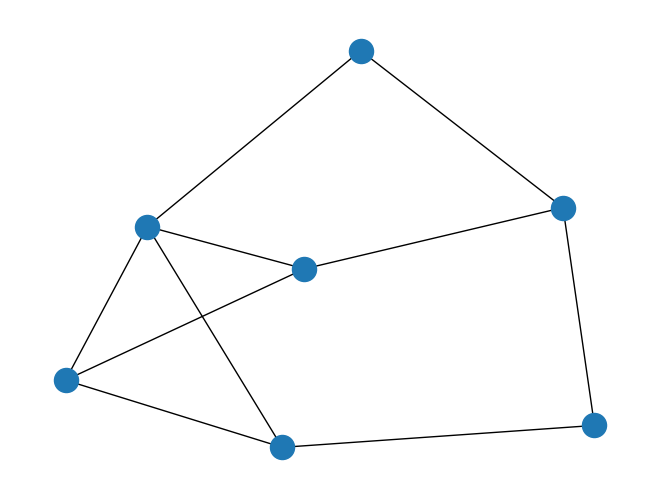

In [5]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=False)

In [6]:
import pandas as pd
import plotly.express as px

In [7]:
colors = dict(zip(['AND','OR','XOR','start_dummy','NOT','NAND','NOR',None],px.colors.qualitative.Vivid))
colors

{'AND': 'rgb(229, 134, 6)',
 'OR': 'rgb(93, 105, 177)',
 'XOR': 'rgb(82, 188, 163)',
 'start_dummy': 'rgb(153, 201, 69)',
 'NOT': 'rgb(204, 97, 176)',
 'NAND': 'rgb(36, 121, 108)',
 'NOR': 'rgb(218, 165, 27)',
 None: 'rgb(47, 138, 196)'}

In [8]:
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'
def rgb_string_to_tuple(rgb:str) -> tuple[int,int,int]:
    return tuple(int(c) for c in rgb.replace("rgb(","").replace(")","").split(","))

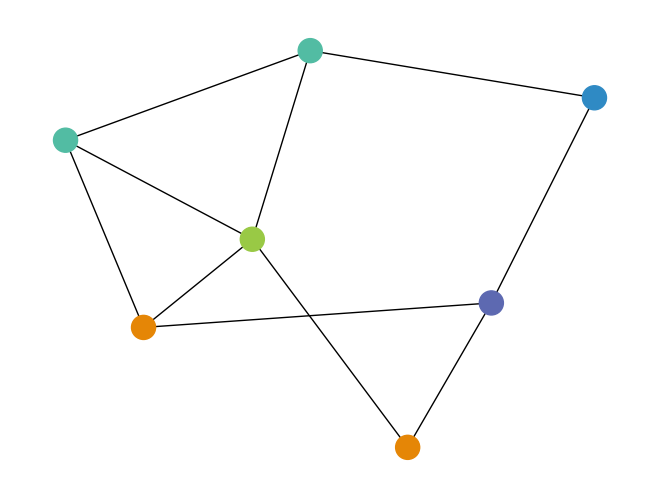

In [9]:
node_colors = [rgb_to_hex(*rgb_string_to_tuple(colors[gate])) for _,gate in G.nodes(data='type')]
nx.draw(G, node_color=node_colors)

In [10]:
import pandas as pd
import plotly.express as px

In [11]:
import plotly.graph_objects as go
def px_plot_network_graph_nodes(G:nx.Graph, *, layout=None, **pxkwargs) -> go.Figure:
    # generate the x/y coordinates to represent the graph
    positions = (layout or nx.spring_layout(G))
    # prepare as DataFrame for plotly
    df = pd.DataFrame([{"label": k, "x": v[0], "y": v[1], "size":10, **G.nodes(data=True)[k]} for k,v in positions.items()])
    for column in df.columns[(df.sample(100, replace=True).map(type) == set).any(axis=0)]:
        print(f"Coercing column '{column}' to `list`")
        df.loc[~df[column].isna(), column] = df.loc[~df[column].isna(),column].apply(list)
    # handle missing values for size/color parameter
    size = pxkwargs.pop("size", "size")
    df[size] = df[size].fillna(df[size].max())
    color = pxkwargs.get("color")
    df[color] = df[color].fillna(df["type"])
    # create figure
    fig = px.scatter(df, x="x", y="y", hover_data=df.columns, size=size, **pxkwargs)
    fig.update_layout(
        xaxis=go.layout.XAxis(visible=False),
        yaxis=go.layout.YAxis(visible=False)
    )
    return fig


def px_plot_nx(G:nx.Graph, *, layout=nx.spring_layout, with_edges=False, **nodekwargs) -> go.Figure:
    nodes = layout(G)
    edges = [{
        "x": [nodes[source][0],nodes[target][0]], 
        "y": [nodes[source][1],nodes[target][1]]} for source, target in G.edges()
    ]
    # Plot nodes
    figure = px_plot_network_graph_nodes(G, layout=nodes, **nodekwargs)
    if with_edges: # Add edges to nodes
        figure.add_traces([
            px.line(
                x=edge["x"],
                y=edge["y"],
                color_discrete_sequence=["grey"],
            ).data[0] for edge in edges
        ])
        figure.data = figure.data[::-1] # shuffle edges behind nodes
    return figure

In [12]:
from functools import partial

layout = (
    nx.spring_layout
)  # partial(nx.spring_layout,k=0.1, iterations=20) # or customize how the layout is generated
px_plot_nx(
    G,
    color="type",
    layout=layout,
    with_edges=True,
    hover_name="type",
    template="plotly_dark",
)  # ,text="label")


In [13]:
print_dict(graph)

Start start_dummy ['A', 'B', 'CIN'] ['g1', 'g2', 'g3', 'g4'] None None
g1 XOR ['XOR1'] ['g2', 'g4'] None None
g2 XOR ['SUM'] ['end_point'] None None
g3 AND ['AND1'] ['g5'] None None
g4 AND ['AND2'] ['g5'] None None
g5 OR ['COUT'] ['end_point'] None None
